In [ ]:
!sudo apt update
!sudo apt install -y tesseract-ocr


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,160 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,326 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https://ppa.lau

In [ ]:
!pip install pytesseract


In [143]:
!pip install Pillow
!pip install pytesseract opencv-python Pillow


In [ ]:
import pytesseract

# Specify the tesseract command path
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


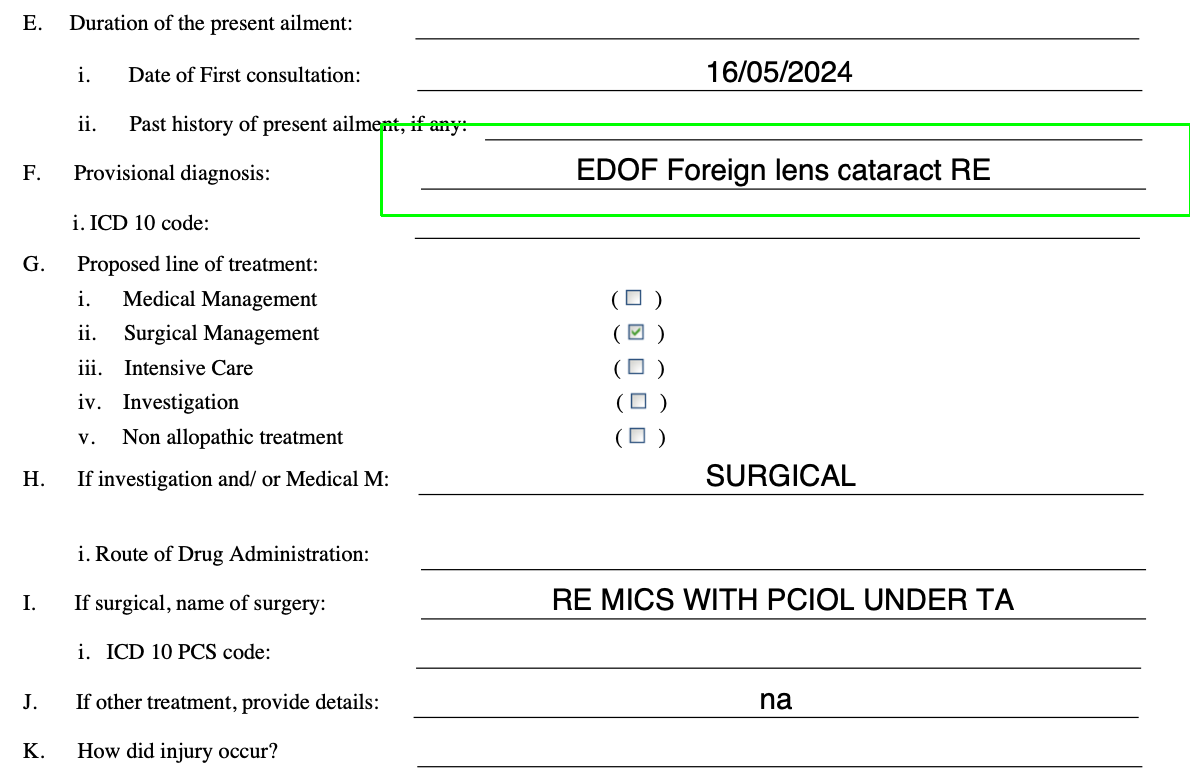

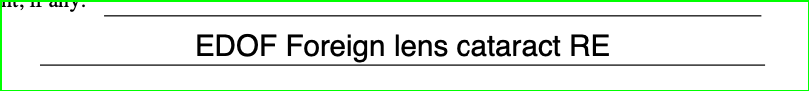

[{'text': 'E.', 'box': {'x': 23, 'y': 14, 'width': 19, 'height': 16}}, {'text': 'Duration', 'box': {'x': 69, 'y': 14, 'width': 79, 'height': 16}}, {'text': 'of', 'box': {'x': 154, 'y': 14, 'width': 20, 'height': 16}}, {'text': 'the', 'box': {'x': 178, 'y': 14, 'width': 26, 'height': 16}}, {'text': 'present', 'box': {'x': 210, 'y': 16, 'width': 65, 'height': 19}}, {'text': 'ailment:', 'box': {'x': 280, 'y': 14, 'width': 71, 'height': 16}}, {'text': 'i.', 'box': {'x': 78, 'y': 66, 'width': 12, 'height': 16}}, {'text': 'Date', 'box': {'x': 128, 'y': 66, 'width': 42, 'height': 16}}, {'text': 'of', 'box': {'x': 176, 'y': 66, 'width': 20, 'height': 16}}, {'text': 'First', 'box': {'x': 200, 'y': 66, 'width': 41, 'height': 16}}, {'text': 'consultation:', 'box': {'x': 246, 'y': 66, 'width': 113, 'height': 16}}, {'text': '16/05/2024', 'box': {'x': 708, 'y': 60, 'width': 144, 'height': 23}}, {'text': 'ii.', 'box': {'x': 78, 'y': 115, 'width': 18, 'height': 16}}, {'text': 'Past', 'box': {'x': 129,

In [190]:
import numpy as np
import cv2
import pytesseract
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz

def preprocess_image(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    orig_height, orig_width = gray.shape
    height, width = orig_height, orig_width
    scale_factor = 1

    # Resize image if dimensions are less than 800
    if height < 800 or width < 800:
        scale_factor = 2
        gray = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LANCZOS4)

    processed_image = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        65,
        13
    )

    return processed_image, scale_factor, orig_width, orig_height

def extract_text_with_boxes(image_path):
    image = cv2.imread(image_path)
    processed_image, scale_factor, orig_width, orig_height = preprocess_image(image)
    config = "--psm 6 --oem 3"
    data = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DICT, config=config)

    extracted_data = []

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            extracted_data.append({
                'text': text,
                'box': {
                    'x': int(data['left'][i] / scale_factor),
                    'y': int(data['top'][i] / scale_factor),
                    'width': int(data['width'][i] / scale_factor),
                    'height': int(data['height'][i] / scale_factor)
                }
            })

    resized_image = cv2.resize(image, (orig_width, orig_height), interpolation=cv2.INTER_LANCZOS4)

    return resized_image, extracted_data

def draw_bounding_box(image):
    height, width, _ = image.shape
    # Calculate bounding box coordinates for 30% from top and left
    x = int(0.4 * width)
    y = int(0.25 * height)
    box_width = int(width)  # Full width
    box_height = int(0.1 * height)  # Height set to 10% of the image height

    # Draw the bounding box
    cv2.rectangle(image, (x, y), (x + box_width, y + box_height), (0, 255, 0), 2)

    return (x, y, box_width, box_height)  # Return the coordinates of the bounding box

def draw_provisional_diagnosis_box_and_extract_rois(image, extracted_data):
    rois = []
    height, width, _ = image.shape
    best_match = None
    highest_ratio = 0

    # Check if any text exists to find 'diagnosis'
    for item in extracted_data:
        text = item['text']
        box = item['box']

        if is_similar_to_diagnosis(text):
            ratio = fuzz.ratio(text.lower(), "diagnosis")
            if ratio > highest_ratio:
                highest_ratio = ratio
                best_match = item

    # Only draw diagnosis box if we found a match and if the image size is greater than or equal to 800
    if best_match and (height >= 700 and width >= 700):
        box = best_match['box']
        cv2.rectangle(image,
                      (box['x'] + 200, box['y'] - 40),
                      (width, box['y'] + box['height'] + 30),
                      (0, 255, 0), 2)
        roi = image[box['y']-40:box['y'] + box['height']+30, box['x'] + 200:width]
        rois.append(roi)

    return rois

def is_similar_to_diagnosis(text, threshold=50):
    keywords = ["diagnosis"]
    for keyword in keywords:
        if fuzz.ratio(text.lower(), keyword) >= threshold:
            return True
    return False

# Example usage
image_path = "/content/Sample7.png"
image, extracted_data = extract_text_with_boxes(image_path)

# Check image size and draw bounding box if necessary
rois = []  # Initialize rois list
if image.shape[0] < 700 or image.shape[1] < 700:
    # Draw the bounding box for small images
    bounding_box_coords = draw_bounding_box(image)
    # Extract ROI from the drawn bounding box
    x, y, box_width, box_height = bounding_box_coords
    roi = image[y:y + box_height, x:x + box_width]
    rois.append(roi)

# Get ROIs for diagnosis if the image size is adequate
diagnosis_rois = draw_provisional_diagnosis_box_and_extract_rois(image, extracted_data)
rois.extend(diagnosis_rois)

cv2_imshow(image)

for i, roi in enumerate(rois):
    cv2_imshow(roi)
    cv2.imwrite(f"/content/roi_{i}.png", roi)

print(extracted_data)


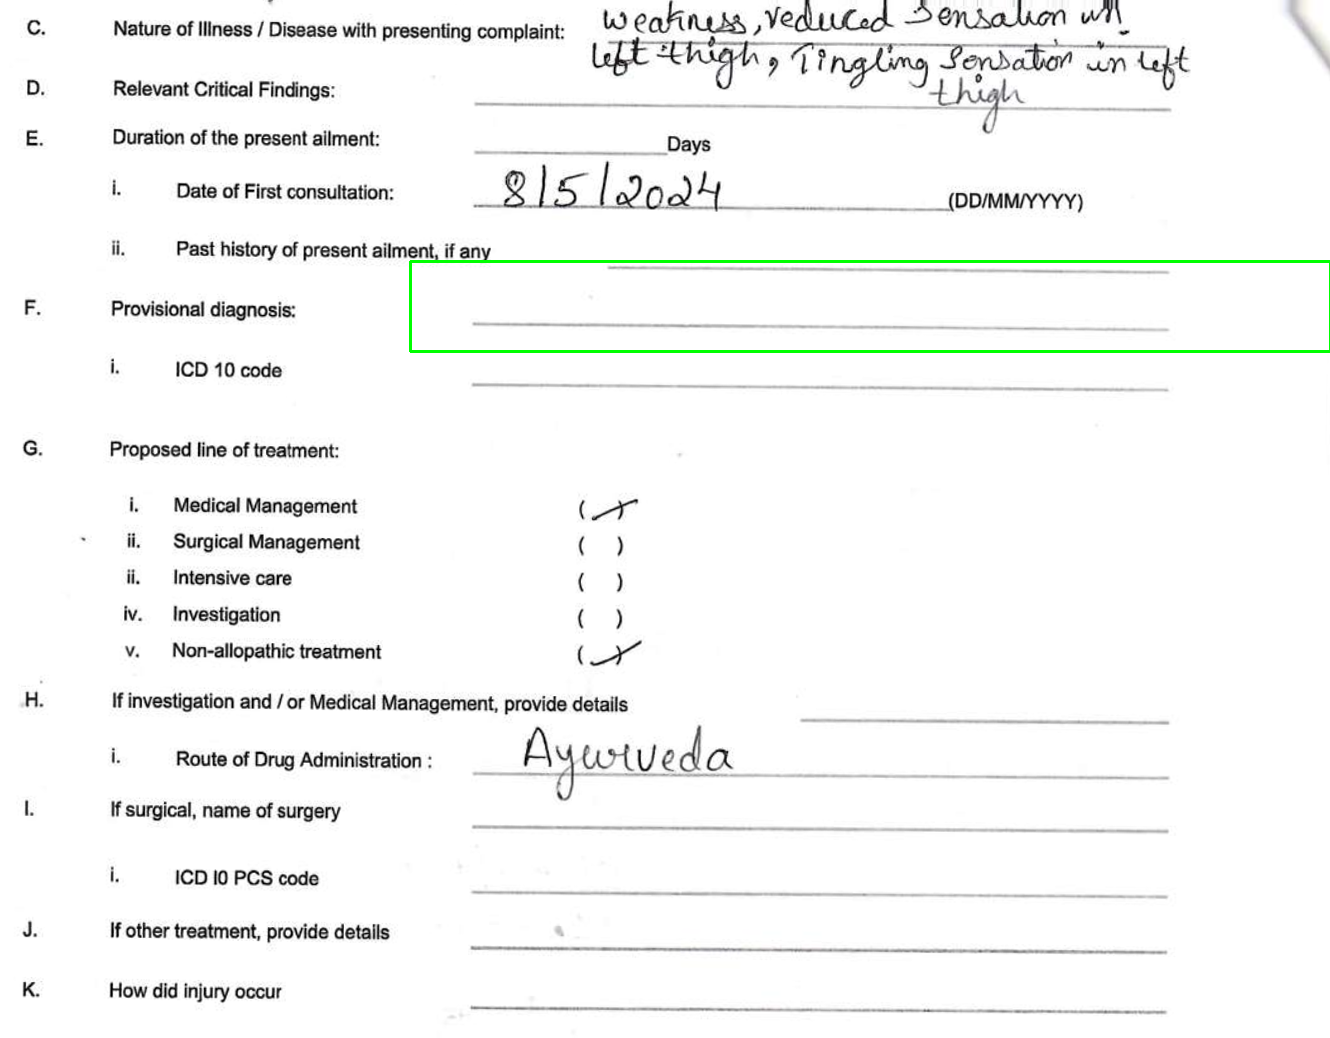

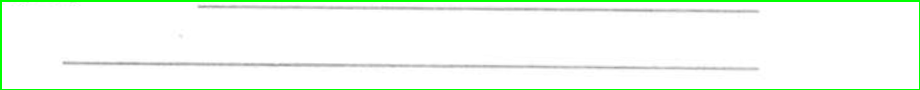

[{'text': 'Pekan', 'box': {'x': 904, 'y': 0, 'width': 162, 'height': 29}}, {'text': 'wit', 'box': {'x': 1081, 'y': 0, 'width': 41, 'height': 24}}, {'text': 'c', 'box': {'x': 27, 'y': 19, 'width': 19, 'height': 17}}, {'text': 'Nature', 'box': {'x': 114, 'y': 20, 'width': 57, 'height': 16}}, {'text': 'of', 'box': {'x': 176, 'y': 20, 'width': 18, 'height': 16}}, {'text': 'IlIness', 'box': {'x': 199, 'y': 20, 'width': 65, 'height': 18}}, {'text': '/', 'box': {'x': 249, 'y': 16, 'width': 17, 'height': 31}}, {'text': 'Disease', 'box': {'x': 269, 'y': 22, 'width': 68, 'height': 16}}, {'text': 'with', 'box': {'x': 342, 'y': 22, 'width': 34, 'height': 16}}, {'text': 'presenting', 'box': {'x': 383, 'y': 23, 'width': 88, 'height': 20}}, {'text': 'complaint:', 'box': {'x': 477, 'y': 23, 'width': 88, 'height': 20}}, {'text': 'w', 'box': {'x': 603, 'y': 9, 'width': 24, 'height': 21}}, {'text': 'eaFinbs', 'box': {'x': 634, 'y': 0, 'width': 107, 'height': 49}}, {'text': 'NeduLed', 'box': {'x': 753, 'y

In [184]:
import cv2
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz
from scipy.ndimage import rotate  # Import rotate directly

# Step 1: Skew correction
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = rotate(arr, angle, reshape=False, order=0)  # Change here
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        _, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC,
                                borderMode=cv2.BORDER_REPLICATE)

    return corrected

# Step 2: Orientation correction
def correct_image_orientation(image):
    (h, w) = image.shape[:2]

    # Skip orientation correction for images smaller than 800x800
    if h < 800 or w < 800:
        return image

    config = "--psm 0"  # Page segmentation mode for orientation detection
    osd = pytesseract.image_to_osd(image, config=config)
    angle = int(osd.split("Rotate: ")[1].split("\n")[0])

    if angle != 0:
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return rotated
    return image

# Step 3: Preprocess image
def preprocess_image(img):
    corrected_img = correct_image_orientation(img)
    gray = cv2.cvtColor(np.array(corrected_img), cv2.COLOR_BGR2GRAY)
    orig_height, orig_width = gray.shape
    height, width = orig_height, orig_width
    scale_factor = 1

    if height < 800 or width < 800:
        scale_factor = 2
        gray = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LANCZOS4)

    processed_image = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        65,
        13
    )

    return processed_image, scale_factor, orig_width, orig_height

# Step 4: Extract text with bounding boxes
def extract_text_with_boxes(image):
    processed_image, scale_factor, orig_width, orig_height = preprocess_image(image)
    config = "--psm 6 --oem 3"

    # Specify DPI setting
    data = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DICT, config=config)

    extracted_data = []
    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            extracted_data.append({
                'text': text,
                'box': {
                    'x': int(data['left'][i] / scale_factor),
                    'y': int(data['top'][i] / scale_factor),
                    'width': int(data['width'][i] / scale_factor),
                    'height': int(data['height'][i] / scale_factor)
                }
            })

    resized_image = cv2.resize(image, (orig_width, orig_height), interpolation=cv2.INTER_LANCZOS4)
    return resized_image, extracted_data

# Step 5: Draw provisional diagnosis box and extract ROIs
def draw_provisional_diagnosis_box_and_extract_rois(image, extracted_data):
    rois = []
    height, width, _ = image.shape
    best_match = None
    highest_ratio = 0

    for item in extracted_data:
        text = item['text']
        box = item['box']

        if is_similar_to_diagnosis(text):
            ratio = fuzz.ratio(text.lower(), "diagnosis")
            if ratio > highest_ratio:
                highest_ratio = ratio
                best_match = item

    # Only draw diagnosis box if we found a match and if the image size is greater than or equal to 800
    if best_match and (height >= 800 and width >= 800):
        box = best_match['box']
        cv2.rectangle(image,
                      (box['x'] + 200, box['y'] - 40),
                      (width, box['y'] + box['height'] + 30),
                      (0, 255, 0), 2)
        roi = image[box['y']-40:box['y'] + box['height']+30, box['x'] + 200:width]
        rois.append(roi)

    return rois

# Helper function to check similarity to "diagnosis"
def is_similar_to_diagnosis(text, threshold=50):
    keywords = ["diagnosis"]
    for keyword in keywords:
        if fuzz.ratio(text.lower(), keyword) >= threshold:
            return True
    return False

# Function to draw bounding box if image size is less than 800
def draw_bounding_box(image):
    height, width, _ = image.shape
    x = int(0.4 * width)  # 40% from left
    y = int(0.25 * height)  # 25% from top
    box_width = int(width)  # Full width
    box_height = int(0.1 * height)  # Height set to 10% of the image height

    # Draw the bounding box
    cv2.rectangle(image, (x, y), (x + box_width, y + box_height), (0, 255, 0), 2)

    return (x, y, box_width, box_height)  # Return the coordinates of the bounding box

# Main flow
if __name__ == '__main__':
    image_path = "/content/Sample12.png"
    image = cv2.imread(image_path)

    # Step 1: Skew correction
    skew_corrected_image = correct_skew(image)

    # Check image size and draw bounding box if necessary
    rois = []  # Initialize rois list
    height, width = skew_corrected_image.shape[:2]

    if height < 800 or width < 800:
        # Draw the bounding box for small images
        bounding_box_coords = draw_bounding_box(skew_corrected_image)
        x, y, box_width, box_height = bounding_box_coords
        roi = skew_corrected_image[y:y + box_height, x:x + box_width]
        rois.append(roi)

    # Step 2: Extract text and draw diagnosis box for larger images
    extracted_image, extracted_data = extract_text_with_boxes(skew_corrected_image)
    diagnosis_rois = draw_provisional_diagnosis_box_and_extract_rois(extracted_image, extracted_data)
    rois.extend(diagnosis_rois)

    # Display the final image and ROI
    cv2_imshow(extracted_image)

    for i, roi in enumerate(rois):
        cv2_imshow(roi)
        cv2.imwrite(f"/content/roi_{i}.png", roi)

    print(extracted_data)


Saving Sample1.png to Sample1.png
Saving Sample2.png to Sample2.png
Saving Sample3.png to Sample3.png
Saving Sample4.png to Sample4.png
Saving Sample5.png to Sample5.png
Saving Sample6.png to Sample6.png
Saving Sample7.png to Sample7 (1).png
Saving Sample8.png to Sample8.png
Saving Sample9.png to Sample9 (1).png
Saving Sample10.png to Sample10 (1).png
Saving Sample11.png to Sample11.png
Saving Sample12.png to Sample12.png
Saving Sample13.png to Sample13.png
Saving Sample14.png to Sample14 (1).png
Saving Sample15.png to Sample15.png
Saving Sample16.png to Sample16.png
Saving Sample17.png to Sample17 (1).png
Saving Sample18.png to Sample18.png
Saving Sample19.png to Sample19.png
Saving Sample20.png to Sample20.png
Saving Sample21.png to Sample21.png
Saving Sample22.png to Sample22.png
Saving Sample23.png to Sample23.png
Saving Sample24.png to Sample24.png
Saving Sample25.png to Sample25 (1).png
Saving Sample26.png to Sample26.png
Saving Sample27.png to Sample27.png
Saving Sample28.png to

error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:798: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'
